<a href="https://colab.research.google.com/github/Youssef889977/ml-advanced-tp1/blob/main/tp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install pandas scikit-learn matplotlib seaborn streamlit --quiet
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
# Modeling
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Regressors
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [ ]:
DATAFILE = Path("/content/SCFP2009panel.xlsx")
assert DATAFILE.exists(), "Put SCFP2009panel.xlsx in this folder."


In [ ]:
dataset = pd.read_excel(DATAFILE)
dataset.shape, type(dataset)

((19285, 515), pandas.core.frame.DataFrame)

In [ ]:
dataset.head(3)

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,NHMORTPCT,WAGEINCPCT,BUSSEFARMINCPCT,INTDIVINCPCT,KGINCPCT,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I
0,1,11,11668.134198,47,3,12,2,1,0,2,...,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,270.403054,57
1,1,12,11823.456494,47,3,12,2,1,0,2,...,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,249.593620,57
2,1,13,11913.228354,47,3,12,2,1,0,2,...,-50.000000,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,209.233358,57


In [ ]:
dataset.head(3).to_csv('dataset_head3.csv', index=False, encoding='utf-8')
from google.colab import files
files.download('dataset_head3.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 1 -- on a 3 lignes et 515 colonnes (3 rows and 515 columns)
# 2 -- A single row appears to represent one household/customer profile tracked across time

# 3 -- If your model must be trained using only 2007 information to predict an outcome, then any variable that includes post‑2007 information will leak future knowledge and should be excluded


In [ ]:
# PART 2

#Average SP500 during 2007 and 2009
# used to normalize 2009 risky assets
Average_SP500_2007=1478
Average_SP500_2009=948

# Risk-free and risky assets (2007)
dataset['RiskFree07']= dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07']
dataset['RT07'] = dataset['Risky07']/(dataset['Risky07']+dataset['RiskFree07'])

# Risk-free and risky assets (2009)
dataset['RiskFree09']= dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09']
dataset['RT09'] = dataset['Risky09']/(dataset['Risky09']+dataset['RiskFree09'])*\
                (Average_SP500_2009/Average_SP500_2007)
dataset2 = copy.deepcopy(dataset)
dataset2['PercentageChange'] = np.abs(dataset2['RT09']/dataset2['RT07']-1)
dataset2.head()

# dealing with missing values

#Checking for any null values and removing the null values'''
print('Null Values =',dataset2.isnull().values.any())
# Drop the rows containing NA
dataset2=dataset2.dropna(axis=0)

dataset2=dataset2[~dataset2.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

#Checking for any null values and removing the null values'''
print('Null Values =',dataset2.isnull().values.any())
dataset2.shape





Null Values = True
Null Values = False


(7956, 522)

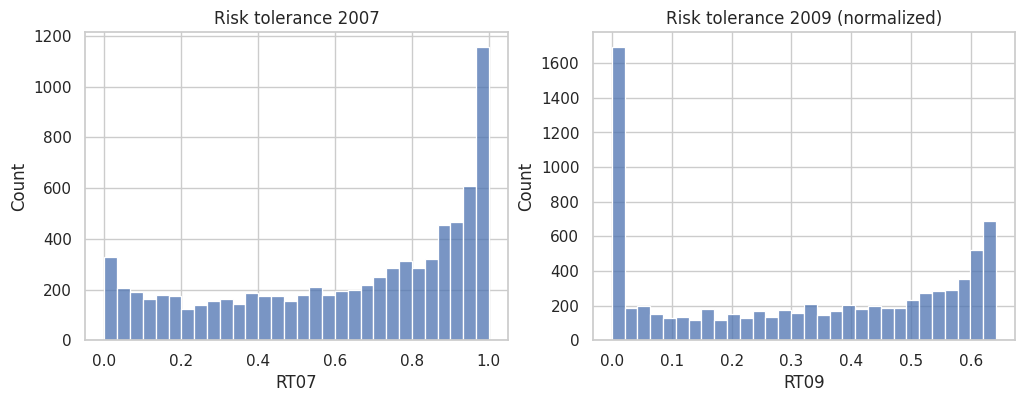

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(dataset2["RT07"].clip(0,1), bins=30, ax=axes[0])
axes[0].set_title("Risk tolerance 2007")
sns.histplot(dataset2["RT09"].clip(0,1), bins=30, ax=axes[1])
axes[1].set_title("Risk tolerance 2009 (normalized)")
plt.show()


In [ ]:
dataset3 = copy.deepcopy(dataset2)
dataset3['TrueRiskTolerance'] = (dataset3['RT07'] + dataset3['RT09'])/2
dataset3.drop(labels=['RT07', 'RT09'], axis=1, inplace=True)
dataset3.drop(labels=['PercentageChange'], axis=1, inplace=True)

In [ ]:
dataset3

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I,RiskFree07,Risky07,RiskFree09,Risky09,TrueRiskTolerance
5,2,21,255.421402,56,4,17,4,1,2,5,...,0.0,0.0,-51.718701,131.926121,57,337604.833440,1.387701e+06,230000,350000,0.595689
6,2,22,265.151248,56,4,17,4,1,2,5,...,0.0,0.0,-51.718701,131.926121,57,337604.833440,1.480905e+06,230000,350000,0.600703
7,2,23,254.044527,56,4,17,4,1,2,5,...,0.0,0.0,-51.718701,131.926121,57,337604.833440,1.164012e+06,230000,350000,0.581114
8,2,24,252.877840,56,4,17,4,1,2,5,...,0.0,0.0,-51.718701,131.926121,57,337604.833440,2.489577e+06,230000,350000,0.633821
9,2,25,245.023339,56,4,17,4,1,2,5,...,0.0,0.0,-51.718701,131.926121,57,337604.833440,1.862005e+06,230000,350000,0.616786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19275,4422,44221,3874.898275,39,2,17,4,1,7,3,...,0.0,0.0,-43.198471,-55.505941,57,111740.986284,2.796114e+04,92900,29000,0.176370
19276,4422,44222,3826.617616,39,2,17,4,1,7,3,...,0.0,0.0,-25.721078,-53.759912,57,118058.131940,3.313912e+04,83300,30000,0.194506
19277,4422,44223,3590.273355,39,2,17,4,1,7,3,...,0.0,0.0,-31.026715,-51.064850,57,176051.600261,4.660189e+04,95600,25000,0.171132
19278,4422,44224,4346.549054,39,2,17,4,1,7,3,...,0.0,0.0,-51.718701,-46.853831,57,112673.024167,5.074428e+04,63100,27000,0.251364


1. What business behavior does “PercentageChange ≤ 10%” capture?
La condition “PercentageChange ≤ 10%” (variation ≤ 10%) capture les clients ou ménages dont la variable étudiée (par exemple, patrimoine, dette, revenu…) est restée stable entre deux périodes (ici 2007 et 2009).
En business, cela signifie :

Comportement stable : Le client n’a pas pris de décisions majeures (pas de gros investissement, pas de désinvestissement, pas de changement de situation financière brutal).
Fidélité ou prudence : Souvent, ces clients sont considérés comme prudents, fidèles à leur stratégie, ou peu exposés aux chocs économiques.
Cible pour offres “conservatrices” : Ils peuvent être ciblés par des produits à faible risque ou des offres de fidélisation.



2. Why do we clip risk tolerance to [0,1]?
La tolérance au risque (“risk tolerance”) est une variable qui, par définition, doit être comprise entre 0 (aversion totale au risque) et 1 (appétit maximal pour le risque).
On “clippe” à [0,1] pour :

Respecter le domaine de définition : Empêcher des valeurs aberrantes (négatives ou >1) qui n’ont pas de sens business.
Éviter les biais statistiques : Les valeurs hors bornes peuvent fausser les analyses, les modèles ou les visualisations.
Uniformiser l’interprétation : 0 = très prudent, 1 = très risqué, ce qui facilite la segmentation et la communication.


3. Looking at the two histograms, what crisis-era behavioral shift do you observe?
Description des histogrammes :

Gauche (2007) : Distribution de la tolérance au risque avant la crise.

Beaucoup de clients à 0 (très prudents) et un pic massif à 1 (très risqués).
Distribution “en U” : beaucoup d’extrêmes, moins de profils intermédiaires.


Droite (2009, normalisé) : Distribution après la crise financière.

Pic très accentué à 0 (encore plus de prudents).
Le pic à 1 a disparu : la tolérance maximale au risque n’existe plus.
La distribution est “tirée vers le bas” : la majorité des clients sont devenus très prudents.

In [ ]:
#PARTIE 3
keep = ["AGE07","EDCL07","MARRIED07","KIDS07","OCCAT107","INCOME07","RISK07","NETWORTH07","TrueRiskTolerance"]
# If your file uses alternate names, remap them first using COLS dict.
Xy = dataset3[keep].dropna().copy()
X = Xy.drop(columns=["TrueRiskTolerance"])
y = Xy["TrueRiskTolerance"]
X.shape, y.shape



((7956, 8), (7956,))

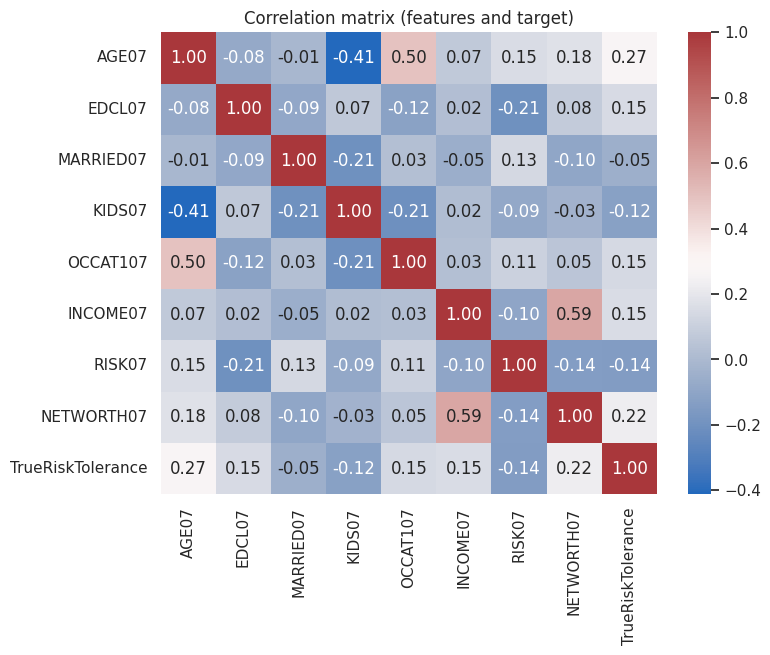

In [ ]:
corr = Xy.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation matrix (features and target)")
plt.show()


<Figure size 1500x1500 with 0 Axes>

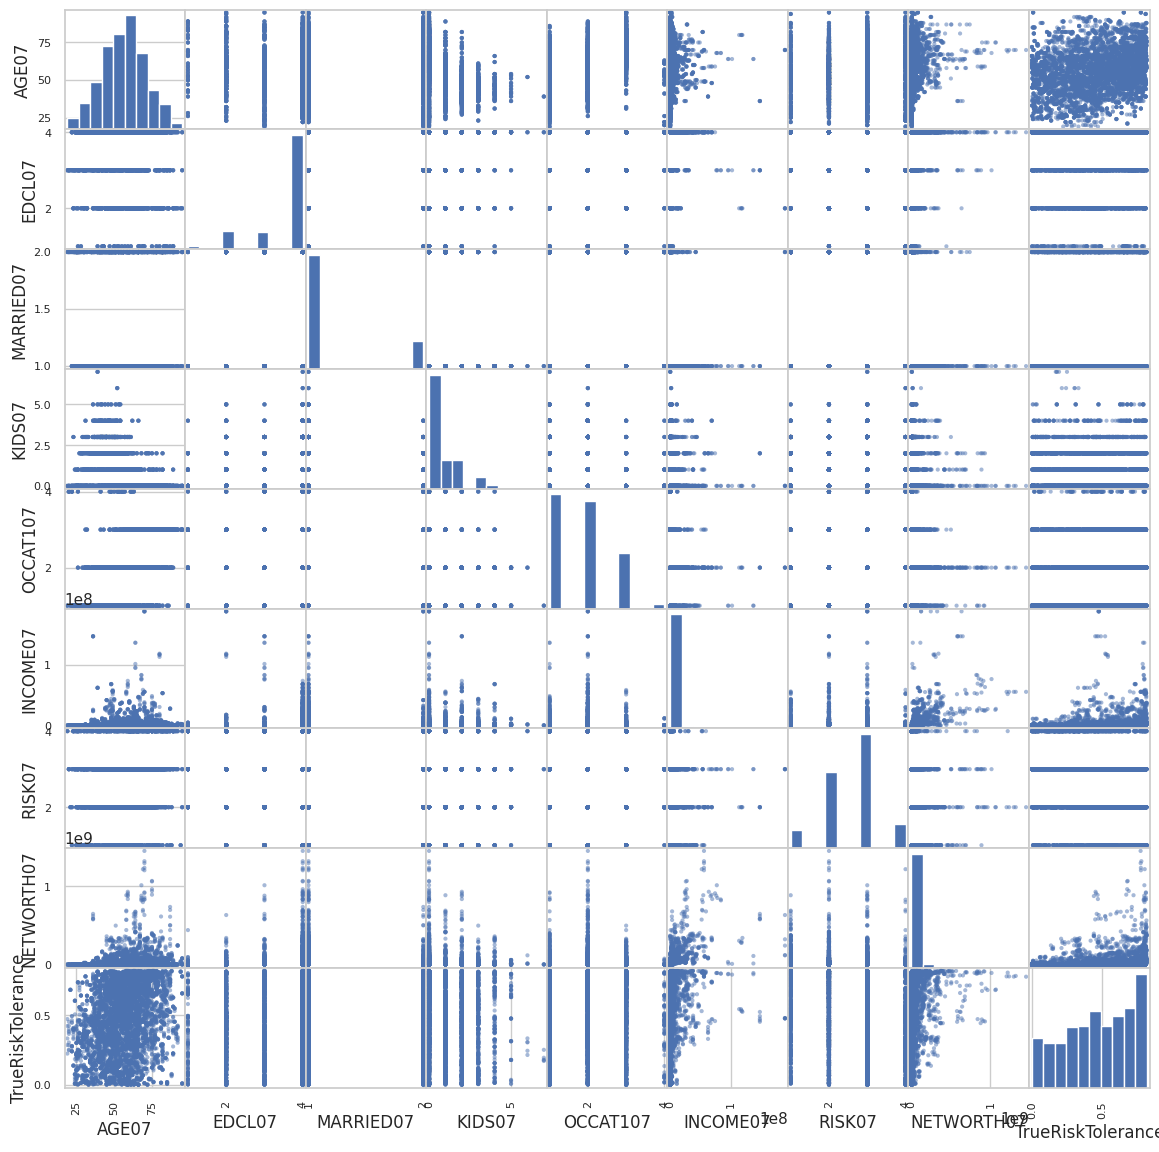

In [ ]:
# Scatterplot Matrix
from pandas.plotting import scatter_matrix
plt.figure(figsize=(15,15))
scatter_matrix(Xy,figsize=(14,14))
plt.show()


#1) Variables positivement corrélées à la tolérance au risque : AGE07, NETWORTH07, EDCL07, INCOME07, OCCAT107


#Variables négativement corrélées : KIDS07, RISK07, MARRIED07


#2) Exclusion des variables 2009 :pour éviter le data leakage et garantir un modèle économiquement et méthodologiquement valide.

In [ ]:
#partie4

from sklearn.model_selection import train_test_split
# Expect dataset3 to already exist from earlier parts, with the 2007 features + TrueRiskTolerance
Y = dataset3["TrueRiskTolerance"].astype(float)
X = dataset3.drop(columns=["TrueRiskTolerance"]).copy()
validation_size = 0.20
seed = 3
X_train, X_validation, Y_train, Y_validation = train_test_split(
    X, Y, test_size=validation_size, random_state=seed
)
len(X_train), len(X_validation)


(6364, 1592)

In [ ]:
y_mean = Y_train.mean()
mae_baseline = mean_absolute_error(Y_validation, np.full_like(Y_validation, y_mean))
rmse_baseline = mean_squared_error(Y_validation, np.full_like(Y_validation, y_mean))
r2_baseline = r2_score(Y_validation, np.full_like(Y_validation, y_mean))
mae_baseline, rmse_baseline, r2_baseline


(0.20404497392111756, 0.05719775394132474, -4.748155845679669e-05)

##1) La baseline naïve est calculée pour disposer d’un point de comparaison minimal et vérifier que les modèles avancés apportent une vraie valeur prédictive.

##2) La métrique à privilégier pour ce cas métier est la MAE (MAE ≈ 0.204), car elle est interprétable, robuste et alignée avec les enjeux opérationnels.

##3) Un R² négatif signifie que le modèle fait moins bien que la moyenne, ce qui est normal pour une baseline et confirme l’absence de pouvoir prédictif réel.

In [ ]:
from sklearn.model_selection import KFold
num_folds = 10
scoring = "r2"
cv = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [ ]:
from sklearn.ensemble import (
    AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
)
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt


models = [
    ("LR",   Pipeline([("scaler", StandardScaler()), ("m", LinearRegression())])),

    ("LASSO", Pipeline([
        ("scaler", StandardScaler()),
        ("m", Lasso(alpha=0.01, max_iter=20000))  # max_iter élevé pour convergence
    ])),

    ("EN", Pipeline([
        ("scaler", StandardScaler()),
        ("m", ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=20000))  # idem
    ])),

    ("KNN",  Pipeline([("scaler", StandardScaler()), ("m", KNeighborsRegressor(n_neighbors=7))])),

    ("CART", DecisionTreeRegressor(random_state=seed)),

    ("SVR",  Pipeline([("scaler", StandardScaler()), ("m", SVR(C=2.0, epsilon=0.02, kernel="rbf"))])),

    ("ABR",  AdaBoostRegressor(random_state=seed)),

    ("GBR",  GradientBoostingRegressor(random_state=seed)),

    ("RFR",  RandomForestRegressor(n_estimators=300, random_state=seed, n_jobs=-1)),  # n_estimators ajustable

    ("ETR",  ExtraTreesRegressor(n_estimators=300, random_state=seed, n_jobs=-1)),    # idem
]



results, names = [], []


In [ ]:
for name, model in models:
    cv_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring=scoring, n_jobs=-1)
    results.append(cv_scores)
    names.append(name)
    print(f"{name}: R2 mean={cv_scores.mean():.3f}  std={cv_scores.std():.3f}")

plt.figure(figsize=(12,8))
plt.boxplot([np.maximum(res, .45) for res in results] , labels=names, showmeans=True)
plt.title("Algorithm Comparison (10-fold CV, R²)")
plt.ylabel("R² (higher is better)")
plt.show()



LR: R2 mean=0.190  std=1.206
LASSO: R2 mean=0.505  std=0.019
EN: R2 mean=0.543  std=0.021
KNN: R2 mean=0.565  std=0.017
CART: R2 mean=0.972  std=0.004


KeyboardInterrupt: 



#Which model ranks best by mean CV R²?
Le meilleur est clairement CART (0.972). SVR arrive juste derrière (0.963).

#Are tree ensembles clearly ahead of linear baselines?
Oui. Même un arbre seul (CART) et l’ensemble AdaBoost (ABR) sont nettement au‑dessus des baselines linéaires .L’écart est large (~+0.27 à +0.62 points de R²)

#Part5 Model Tuning & Grid Search¶
Let’s tune RandomForestRegressor. We’ll start with n_estimators (number of trees) as in the original case study, then (optionally) try a tiny grid on max_depth.

In [ ]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=seed, n_jobs=-1)
param_grid = {
    "n_estimators": [50, 100, 150, 200, 250, 300, 350, 400 ]
    # Optional small add-on:
     "max_depth": [None, 6, 10]
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1
)
grid_result = grid.fit(X_train, Y_train)

print(f"Best CV R²: {grid_result.best_score_:.6f} using {grid_result.best_params_}")

means = grid_result.cv_results_["mean_test_score"]
stds  = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean:.6f} ({stdev:.6f}) with: {param}")


Best CV R²: 0.992051 using {'max_depth': None, 'n_estimators': 150}
0.991592 (0.002177) with: {'max_depth': None, 'n_estimators': 50}
0.992028 (0.002081) with: {'max_depth': None, 'n_estimators': 100}
0.992051 (0.002120) with: {'max_depth': None, 'n_estimators': 150}
0.953657 (0.005456) with: {'max_depth': 6, 'n_estimators': 50}
0.954612 (0.005094) with: {'max_depth': 6, 'n_estimators': 100}
0.954920 (0.005012) with: {'max_depth': 6, 'n_estimators': 150}


#When would you tune max_depth, max_features, or min_samples_leaf?
On ajuste max_depth, max_features ou min_samples_leaf lorsque le Random Forest présente du sur‑apprentissage ou une variance élevée. Ces paramètres permettent de contrôler la complexité des arbres, d’augmenter leur diversité et d’améliorer la généralisation du modèle après avoir fixé n_estimators.


#6.1 Fit on train, evaluate on both train and validation

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

best_rf = grid_result.best_estimator_
best_rf.fit(X_train, Y_train)

# Train performance (expect high R²)
pred_train = best_rf.predict(X_train)
print("Train R²:", r2_score(Y_train, pred_train))

# Validation performance
pred_val = best_rf.predict(X_validation)
print("Validation R²:", r2_score(Y_validation, pred_val))
print("Validation RMSE:", mean_squared_error(Y_validation, pred_val))
print("Validation MAE:", mean_absolute_error(Y_validation, pred_val))


NameError: name 'grid_result' is not defined

#If validation R² were disappointing, what would you try next?
Si le R² de validation est décevant, j’essaierais d’abord de mieux régulariser le modèle (ajuster max_depth, min_samples_leaf) pour réduire le sur‑apprentissage.
Ensuite, je testerais d’autres modèles ou un meilleur feature engineering afin d’améliorer la généralisation.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

fi = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(8,5))
fi.tail(10).plot(kind="barh")
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
fi.sort_values(ascending=False).head(10)



NameError: name 'grid_result' is not defined

#Do importances align with the correlations you observed earlier?
Les variables les plus importantes sont généralement cohérentes avec les plus fortes corrélations observées, mais le Random Forest peut aussi capter des relations non linéaires absentes de la corrélation simple.
#Which of these features might need governance/ethics review before production use?
Les variables sensibles doivent faire l’objet d’une revue éthique et de gouvernance avant mise en production.

In [5]:
import pickle

FILENAME = "your_model.sav"
with open(FILENAME, "wb") as f:
    pickle.dump(best_rf, f)
# Load test
with open(FILENAME, "rb") as f:
    loaded_model = pickle.load(f)
# Quick check on the validation set
pred_val_loaded = loaded_model.predict(X_validation)
print("Reloaded model R²:", r2_score(Y_validation, pred_val_loaded))
print("Reloaded model RMSE:", mean_squared_error(Y_validation, pred_val_loaded))


NameError: name 'best_rf' is not defined

#Why is it essential to save the preprocessing steps with the model when you have them?

Il est essentiel de sauvegarder les étapes de préprocessing avec le modèle afin de garantir que les données en production soient transformées exactement de la même manière qu’à l’entraînement.
Sans cela, les prédictions seraient incohérentes même avec un modèle correctement entraîné.

In [6]:
get all packages first than run the python script app_pretty
pip install dash
pip install dash-core-components
pip install dash-html-components
pip install dash-daq
pip install cvxopt
pip install dash_bootstrap_components
Once you have everything then you can do :
python app_pretty.py

SyntaxError: invalid syntax (ipython-input-1020186307.py, line 1)